In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from time import time
%matplotlib inline
%run utils.py
pd.options.display.max_columns = None

In [10]:
# collection et pretraitement de donnees

training_original = pd.read_csv("training.csv")
testing_original = pd.read_csv("testing.csv")

training_quant = training_original.drop(columns=["class"])
testing_quant = testing_original.drop(columns=["class"])

labels_training = training_original["class"]
labels_testing = testing_original["class"]

training_grad= training_quant.iloc[:,1:-1].to_numpy()-training_quant.iloc[:,2:].to_numpy()
testing_grad= testing_quant.iloc[:,1:-1].to_numpy()-testing_quant.iloc[:,2:].to_numpy()

training_grad= pd.DataFrame(training_grad,columns=[f"G{i}" for i in range(1,1+training_grad.shape[1])])
testing_grad= pd.DataFrame(testing_grad,columns=[f"G{i}" for i in range(1,1+testing_grad.shape[1])])

In [3]:
# choix de donnees 
training_data = pd.concat((training_quant,training_grad),axis=1)
testing_data = pd.concat((testing_quant,testing_grad),axis=1)

# Apprentissage automatique

## Non supervisé (clustering)

### Hierarchical clustering

Type de linkage est:  ward   ARI score est:  0.14700631005851073
Type de linkage est:  complete   ARI score est:  0.10973314326045178
Type de linkage est:  average   ARI score est:  -0.08871008363949516
Type de linkage est:  single   ARI score est:  0.0002873120826966663


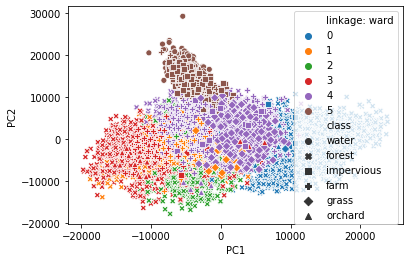

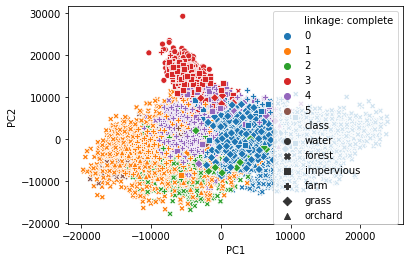

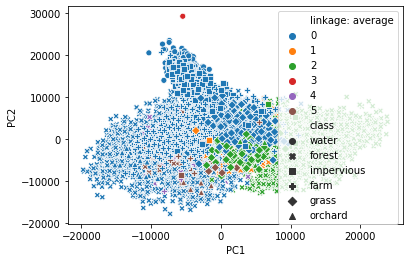

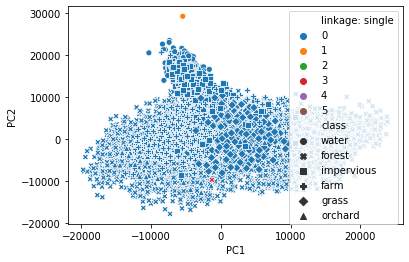

In [4]:
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
linkage=["ward", "complete", "average","single"]

for i in linkage:
    clustering = AgglomerativeClustering(n_clusters=6,linkage=i).fit(training_data)
    labels_pred = pd.Series(clustering.labels_ , name="linkage: "+i)
    ari= adjusted_rand_score(labels_true=labels_training,labels_pred=labels_pred)
    print("Type de linkage est: ",i,"  ARI score est: ",ari)
    plt.figure()
    scatterplot_pca(data=training_data,hue=labels_pred,style=labels_training)

    on peut dire ce modele n'est pas bonne pour notre jeu de donnees qui possede des inerties intra classe pas assez faible.

### K-means

-79060195800.82059


0.12791057044145726

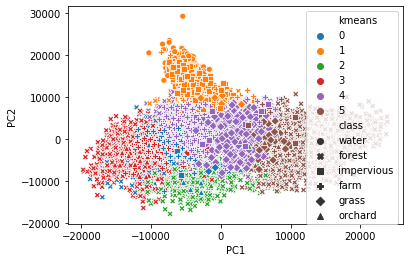

In [5]:
from sklearn.cluster import KMeans

sample_weight={}

kmeans = KMeans(n_clusters=6,n_jobs=-1)
kmeans.fit(training_data,sample_weight=None)
labels_pred = pd.Series(kmeans.labels_,name="kmeans")
print(kmeans.score(testing_data))
scatterplot_pca(data=training_data,hue=labels_pred,style=labels_training)
ari= adjusted_rand_score(labels_true=labels_training,labels_pred=labels_pred)
ari

## Supervisé (classification)

In [6]:
#retirer training set et validation set

# This cross-validation object is a variation of KFold that returns stratified folds.
# The folds are made by preserving the percentage of samples for each class.

from sklearn.model_selection import StratifiedKFold

skf=StratifiedKFold(n_splits=10,shuffle=True)
for train_idx,val_idx in skf.split(training_data,labels_training):
    print('Train: %s | Val: %s' % (train_idx, val_idx))
    print(" ")
    #print("train_x: ",training_data[train_idx])
    #print("train_y: ",labels_training[train_idx])
    #print("val_x:", training_data[val_idx])
    #print("val_y:", labels_training[val_idx])


Train: [    0     2     3 ... 10542 10543 10544] | Val: [    1     7    19 ... 10519 10528 10529]
 
Train: [    0     1     2 ... 10541 10542 10544] | Val: [    6     8    15 ... 10523 10534 10543]
 
Train: [    1     4     5 ... 10541 10543 10544] | Val: [    0     2     3 ... 10537 10539 10542]
 
Train: [    0     1     2 ... 10541 10542 10543] | Val: [    9    13    22 ... 10531 10535 10544]
 
Train: [    0     1     2 ... 10542 10543 10544] | Val: [    5    14    20 ... 10511 10515 10532]
 
Train: [    0     1     2 ... 10542 10543 10544] | Val: [   11    16    37 ... 10527 10536 10540]
 
Train: [    0     1     2 ... 10542 10543 10544] | Val: [   23    27    29 ... 10509 10512 10520]
 
Train: [    0     1     2 ... 10542 10543 10544] | Val: [   18    26    45 ... 10497 10498 10538]
 
Train: [    0     1     2 ... 10542 10543 10544] | Val: [   30    53    67 ... 10526 10530 10541]
 
Train: [    0     1     2 ... 10542 10543 10544] | Val: [    4    10    12 ... 10502 10510 10521]
 


### K nearest neighbors

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier(n_jobs=-1)

hyper_param={
    "n_neighbors":range(3,6),
    "weights": ["uniform","distance"],
    "algorithm" :["ball_tree", "kd_tree", "brute"]   
}

grid_search = GridSearchCV(estimator= knn, param_grid= hyper_param, n_jobs= -1,cv= skf, return_train_score=True)

a=time()
grid_result = grid_search.fit(training_data,labels_training)
b=time()

b-a

KeyboardInterrupt: 

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

In [ ]:
grid_result.cv_results_

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier(n_jobs=-1)

hyper_param={
    "n_neighbors":range(2,10),
    "weights": ["distance"],
    "algorithm" :["ball_tree"]   
}

grid_search = GridSearchCV(estimator= knn, param_grid= hyper_param, n_jobs= -1,cv= skf, return_train_score=True)

a=time()
grid_result = grid_search.fit(training_data,labels_training)
b=time()

b-a

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

In [ ]:
knn_best = KNeighborsClassifier(
    n_neighbors=4, 
    weights= "distance", 
    algorithm="ball_tree",
    n_jobs=-1,
)
knn_best.fit(training_data,labels_training)

In [ ]:
labels_pred=pd.Series(knn_best.predict(testing_data),name="KNN")
knn_best.score(testing_data,labels_testing)

In [ ]:
%matplotlib inline

In [ ]:
scatterplot_pca(data=testing_data,hue=labels_pred,style=labels_testing)

### Linear and Quadratic Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda=LinearDiscriminantAnalysis()

hyper_param={
    "solver":["svd","lsqr","eigen"]  
}

grid_search = GridSearchCV(estimator= lda, param_grid= hyper_param, n_jobs= -1,cv= skf)

a=time()
grid_result = grid_search.fit(training_data,labels_training)
b=time()

b-a

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

In [ ]:
lda=LinearDiscriminantAnalysis(solver="lsqr")
lda.fit(training_data,labels_training)
lda.score(testing_data,labels_testing)

In [ ]:
# sns.scatterplot(x=training_lda["L1"],y= training_lda["L2"], hue=labels_training)

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda=QuadraticDiscriminantAnalysis()
training_qda= qda.fit(training_data,labels_training)

In [ ]:
qda.score(testing_data,labels_testing)

In [ ]:
np.set_printoptions(suppress=True)
pd.set_option('float_format', lambda x: '%.3f' % x)
pd.DataFrame(qda.predict_proba(testing_data),columns=qda.classes_)

### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

gnb= GaussianNB()
print(cross_val_score(gnb,training_data,labels_training,cv=skf))
gnb.fit(training_data,labels_training)
gnb.score(testing_data,labels_testing)

In [ ]:
gnb= GaussianNB(priors=np.ones(6)/6)
print(cross_val_score(gnb,training_data,labels_training,cv=skf))
gnb.fit(training_data,labels_training)
labels_pred=pd.Series(gnb.predict(testing_data),name="GNB equal proba")
gnb.score(testing_data,labels_testing)


In [ ]:
scatterplot_pca(data=testing_data,hue=labels_pred,style=labels_testing)

### Tree

#### decisiontree + adaboost

In [12]:
from sklearn.tree import DecisionTreeClassifier

dtc= DecisionTreeClassifier()
print(cross_val_score(dtc,training_data,labels_training,cv=skf))
dtc.fit(training_data,labels_training)
dtc.score(testing_data,labels_testing)

[0.89668246 0.88720379 0.89668246 0.90331754 0.87867299 0.87855787
 0.88519924 0.88614801 0.87571157 0.89373814]


0.52

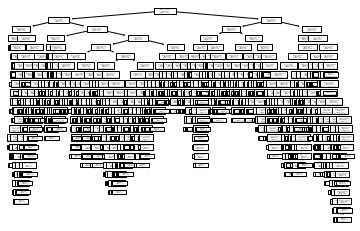

In [14]:
from sklearn.tree import plot_tree
plot_tree(dtc)
plt.show() 

In [15]:
from sklearn.ensemble import AdaBoostClassifier
dtc= DecisionTreeClassifier()
dtc_ada = AdaBoostClassifier(dtc)
dtc_ada.fit(training_data,labels_training)
dtc_ada.score(testing_data,labels_testing)

0.5333333333333333

In [16]:
dtc= DecisionTreeClassifier(class_weight="balanced")
print(cross_val_score(dtc,training_data,labels_training,cv=skf))
dtc.fit(training_data,labels_training)
dtc.score(testing_data,labels_testing)

[0.88720379 0.90331754 0.88436019 0.8957346  0.90047393 0.89658444
 0.91555977 0.91081594 0.90512334 0.90702087]


0.4766666666666667

In [17]:
from sklearn.ensemble import AdaBoostClassifier
dtc= DecisionTreeClassifier(class_weight="balanced")
dtc_ada = AdaBoostClassifier(dtc)
dtc_ada.fit(training_data,labels_training)
dtc_ada.score(testing_data,labels_testing)

0.49

In [18]:
from sklearn.ensemble import AdaBoostClassifier
dtc_ada = AdaBoostClassifier()
dtc_ada.fit(training_data,labels_training)
dtc_ada.score(testing_data,labels_testing)

0.47

#### random forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

rfc= RandomForestClassifier(oob_score=True)
rfc.fit(training_data,labels_training)
print(rfc.oob_score_)
rfc.score(testing_data,labels_testing)

0.9469890943575154


0.62

In [20]:
rfc= RandomForestClassifier(oob_score=True,class_weight="balanced")
rfc.fit(training_data,labels_training)
print(rfc.oob_score_)
rfc.score(testing_data,labels_testing)

0.95049786628734


0.6

In [21]:
rfc= RandomForestClassifier(oob_score=True,class_weight="balanced",n_jobs=-1)
hyper_param={
    "n_estimators":[10,20,50,100] ,
}

grid_search = GridSearchCV(estimator= rfc,param_grid= hyper_param, n_jobs= -1)

a=time()
grid_result = grid_search.fit(training_data,labels_training)
b=time()

b-a

7.7183496952056885

In [22]:
print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))

Best: 0.916453 using {'n_estimators': 100}
0.908393  with:   {'n_estimators': 10}
0.912281  with:   {'n_estimators': 20}
0.915695  with:   {'n_estimators': 50}
0.916453  with:   {'n_estimators': 100}


In [23]:
rfc= RandomForestClassifier(n_estimators=100,oob_score=True,class_weight="balanced",n_jobs=-1,max_samples=200)
rfc.fit(training_data,labels_training)
print(rfc.oob_score_)
rfc.score(testing_data,labels_testing)

0.8751066856330014


0.4766666666666667

In [24]:
class_weight =(10000/training_original["class"].value_counts()).to_dict()
rfc= RandomForestClassifier(n_estimators=100,oob_score=True,class_weight=class_weight,n_jobs=-1)
rfc.fit(training_data,labels_training)
print(rfc.oob_score_)
rfc.score(testing_data,labels_testing)

0.9489805595068753


0.58

1000 fois repetition de forest avec des donnees aleatoires qui possede le nombre identique de individu dans chaque classe

In [25]:
from random import sample

def n_in_each_class(X,y,n=20,boucle=100):
    id_list=[]
    id=[]
    for j in range(boucle):
        for i in y.unique():
            id= id + sample(y[y==i].index.tolist(),n)
        id_list.append(id)
    return id_list
    
nb_sample_in_each_class = 2
nb_trees_in_each_forest =10
nb_boucle=100

oob_list_rf=[]
pred_proba_rf=[]
id_list= n_in_each_class(training_data,labels_training, nb_sample_in_each_class,nb_boucle)


for i in range(nb_boucle):
    x_train, y_train= training_data.iloc[id_list[i]],labels_training.iloc[id_list[i]]
    rfc= RandomForestClassifier(
        n_estimators=nb_trees_in_each_forest,
        n_jobs=-1
    )
    rfc.fit(x_train,y_train)
    pred_proba_rf.append(rfc.predict_proba(testing_data))
    
pred_proba_rf_np= np.array(pred_proba_rf)
pred=pred_proba_rf_np.sum(axis=0)

result=[]
for i in range(300):
    result.append(rfc.classes_[np.argmax(pred[i,:])])
    
score= np.mean(result==labels_testing)
score    

0.71

### Support Vector Machines

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc= SVC()
hyper_param={
#     "kernel":[
#         "linear","poly",
#         "rbf","sigmod"] ,
#     "decision_function_shape":["ovo","ovr"] 
}

grid_search = GridSearchCV(estimator= svc, param_grid= hyper_param, n_jobs= -1,cv= skf)

a=time()
grid_result = grid_search.fit(training_data,labels_training)
b=time()

print("time:  ",b-a)

print("Best: %f using %s" % (grid_result.best_score_,grid_search.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean,param in zip(means,params):
    print("%f  with:   %r" % (mean,param))
svc.fit(training_data,labels_training)
svc.score(testing_data,labels_testing)

In [ ]:
svc= SVC()
svc.fit(training_data,labels_training)
svc.score(testing_data,labels_testing)